# Manual Gaussian Mixture Model Algorithm
### This Jupyter notebook performs the Gaussian Mixture Model algorithm manually, without the use of Scikit-learn.  

#### We make several assumptions in this algorithm example:

1. The dataset contains multiple Gaussian distributions
2. The value of k is 2; that is, the number of clusters we will form in the GMM algorithm is 2
3. The dataset is bivariate.

In [1]:
import math as m
import numpy as np
import random 
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
def multiPDF (row,clust_mean,clust_covar):
    
    """
    this function calculates and returns the Likelihood (Probability Density Function [pdf])
    of a 2-dimensional single row of a dataset belonging to a cluster.
    The input params of this function are:  
    row - the single dataset row you want to find the cluster probability for. It should be an array with x and y variables
    clust_mean - the calculated mean coordinates of the cluster
    clust_covar = the calculated cluster covarance matrix of the cluster
    
    """
    
    #Exponent requires matrix multiplication!
    exponent = (-1/2)*((row-clust_mean).T@np.linalg.inv(clust_covar)@(row-clust_mean))
    fraction = 1/np.sqrt(pow(2*np.pi,len(row))*np.linalg.det(clust_covar)) 
    llh = fraction*pow(np.e,exponent)
       
    return llh

In [3]:
def estep (c1_llh,c2_llh):
    
    """
    Expectation Step of GMM:
    This function calculates the membership probability to each cluster from the cluster likelihoods from multiPDF().
    The input is the likelihood of cluster 1 and 2.
    """
       
    c1_prob,c2_prob = c1_llh/(c1_llh+c2_llh), c2_llh/(c1_llh+c2_llh)
    
    return c1_prob, c2_prob

In [4]:
def recluster (dataset,prob_array):
    
    """
    This function forms the 2 new clusters from the cluster probabilities returned from estep(). This function also
        stores the associated cluster probabilites for each row in dataset in separate arrays.
        
        The input parameters are the full dataset to be clustered and an array of cluter probabilities returned from 
        estep()
    """
    
    #initialize needed variables to store the cluster values and the probabilities
    i=0
    c1_new=[]
    c1_prob = []
    c2_new=[]
    c2_prob = []

    #iterate thru the dataset and store the maximum probability in the appropriate c1_new or c2_new var
    #store the max prob array in c1_prob or c2_prob accordingly.
    while i<len(dataset):

        if(prob_array[i,0]>prob_array[i,1]):
            c1_new.append(dataset[i])
            c1_prob.append(np.max(prob_array[i]))
            #need to include the cluster probability for each row in dataset
        else:
            c2_new.append(dataset[i])
            c2_prob.append(np.max(prob_array[i]))
        i+=1
    
    #convert lists to arrays before returning
    return np.array(c1_new), np.array(c1_prob), np.array(c2_new), np.array(c2_prob)

In [5]:
def mstep (clust, clust_prob):
    
    
    """
    Maximization Step of GMM:
    this function recalculates the new mean and covariance of a cluster from the inputted cluster and 
    assoc. 1D probability array.
    """
    
    #expand the single column probability array into 2 repeated columns for easier calculation
    clust_prob_exp = np.reshape(np.repeat(clust_prob,2,axis=0),(len(clust),clust.ndim))
    
    #calculate the mean of the new cluster
    clust_mean  = np.sum(clust*clust_prob_exp,axis=0)/np.sum(clust_prob)

    
    #calulate the covariance matrix for the new cluster
    diff = clust - clust_mean
    clust_covar = np.dot(((diff).T*clust_prob),diff)/sum(clust_prob)
    
    #add a small value to the diaognal of the covariance matrix 
    #if the inverse of the covariance mtx is 0 to prevent the 'singular matrix' error in multPDF().
    if (np.linalg.det(clust_covar) == 0):
        clust_covar[0,0] = clust_covar[0,0] +1e-6
        clust_covar[1,1] = clust_covar[1,1] +1e-6
    
    return clust_mean, clust_covar

In [6]:
def get_clusters(q):

    """
    This function iterates calls the following functions to determine the Gaussian Mixture Model clusters for 
    the inputted bivariate dataset array, q: multiPDF(), estep(), recluster(), mstep().  
    
    The iteration process repeats until the estep() returned likelihoods do not 
    change between iterations, that is until convergence of clusters occur.
    Display the # of iterations to convergence. Return the resulting 2 clusters.
    """


    #select initial random means and covariences for cluster 1 and 2
    c1_mean = np.array([1,1])
    c1_covar = np.array([[8.3,-3.4],[-3.4,6.7]])

    c2_mean = np.array([15,20])
    c2_covar =np.array([[26.2,10.5],[10.5,11.5]])
    llh_stored = []

    #iterator
    r = 1


    #infinate loop; break when likelihoods are equal
    while True:
        print('\nIteration Nbr:',r)


        #Get the cluster likelihood for each row in dataset q using mutliPDF()
        llh_array = np.empty(shape=(len(q),q.ndim))
        i=0
        for row in q:

            #calculate the likelihoods of q belonging to each cluster
            llh_array[i,0]= multiPDF(row,c1_mean,c1_covar)
            llh_array[i,1]= multiPDF(row,c2_mean,c2_covar)
            i+=1     


        #print('Likelihood array:',llh_array)


        #If the likelihoods are equal rounded to the 9th decimal,
        #convergence has occured.  Display the number of iterations and break the loop.
        #Else update the likelihood array
        if(np.array_equal(np.round(llh_stored,9),np.round(llh_array,9))):
            print('\n# OF ITERATIONS UNTIL CLUSTER CONVERGENCE: ',r)
            break
        else:
            llh_stored = llh_array  

            #calculate cluster probabilities
            prob_array = np.empty(shape=(len(q),q.ndim))

            i=0
            for row in llh_array:
                prob_array[i] = estep(row[0],row[1])
                i+=1
            prob_array
            #print('Prob array',prob_array)


            #Reform the clusters based on the probabilities and create associated 
            #probability arrays for each cluster
            c1,c1_prob,c2,c2_prob = recluster(q,prob_array)


            #Calculate the new cluster means and covariances via mstep()
            c1_mean, c1_covar = mstep(c1,c1_prob)
            print('\nCluster1 mean/covar',c1_mean,'\n',c1_covar)
            #print('\nCluster1: ',c1,'\n')


            c2_mean, c2_covar = mstep(c2,c2_prob)
            print('Cluster2 mean/covar',c2_mean,'\n',c2_covar)    
            #print('\nCluster2: ',c2,'\n')

            r+=1
        
    return c1, c2
        

In [7]:
#define the dataset to cluster
q=np.array([[25,30],[1,2],[2,3],[4,5],[10,20],[20,32],[4,3],[2,2],])
q

array([[25, 30],
       [ 1,  2],
       [ 2,  3],
       [ 4,  5],
       [10, 20],
       [20, 32],
       [ 4,  3],
       [ 2,  2]])

In [8]:
#select initial random means and covariances for cluster 1 and 2
c1_mean = np.array([1,1])
c1_covar = np.array([[8.3,-3.4],[-3.4,6.7]])

c2_mean = np.array([15,26])
c2_covar =np.array([[26.2,10.5],[10.5,11.5]])

In [9]:
#Get the cluster likelihood for each row in dataset q and store in an array
llh_array = np.empty(shape=(len(q),q.ndim))
i=0

for row in q:
    #calculate the likelihoods of q belonging to each cluster
    llh_array[i,0]= multiPDF(row,c1_mean,c1_covar)
    llh_array[i,1]= multiPDF(row,c2_mean,c2_covar)
    i+=1

In [10]:
#Display all likelihoods 
llh_array

array([[4.12303026e-79, 1.70780630e-03],
       [2.18238719e-02, 2.32569132e-14],
       [1.30651851e-02, 1.72161745e-13],
       [1.06095332e-03, 7.25802735e-12],
       [1.59231448e-25, 2.39051562e-03],
       [2.47261825e-73, 2.39051562e-03],
       [5.22163959e-03, 5.82619029e-14],
       [1.87233134e-02, 1.40158733e-14]])

In [11]:
#from the likelihoods, calculate each cluster probability for the query dataset q
#Expectation Step (E-Step)

#create empty array to store probabilities with same shape as dataset q
prob_array = np.empty(shape=(len(q),q.ndim))

#From the likelihood array, calculate the cluster probabilities for each row in dataset q
i=0
for row in llh_array:
    prob_array[i] = estep(row[0],row[1])
    i+=1
prob_array

array([[2.41422593e-76, 1.00000000e+00],
       [1.00000000e+00, 1.06566393e-12],
       [1.00000000e+00, 1.31771378e-11],
       [9.99999993e-01, 6.84104301e-09],
       [6.66096664e-23, 1.00000000e+00],
       [1.03434516e-70, 1.00000000e+00],
       [1.00000000e+00, 1.11577794e-11],
       [1.00000000e+00, 7.48578685e-13]])

In [12]:
#Reform the clusters based on the probabilities and create associated 
#probability arrays for each cluster
c1,c1_prob,c2,c2_prob = recluster(q,prob_array)

In [13]:
c1

array([[1, 2],
       [2, 3],
       [4, 5],
       [4, 3],
       [2, 2]])

In [14]:
c1_prob

array([1.        , 1.        , 0.99999999, 1.        , 1.        ])

In [15]:
c2

array([[25, 30],
       [10, 20],
       [20, 32]])

In [16]:
c2_prob

array([1., 1., 1.])

In [17]:
#Calculate the new cluster means and covariances via mstep()
c1_mean, c1_covar = mstep(c1,c1_prob)
c2_mean, c2_covar = mstep(c2,c2_prob)

In [18]:
c1_mean

array([2.6, 3. ])

In [19]:
c1_covar

array([[1.44, 1.  ],
       [1.  , 1.2 ]])

In [20]:
c2_mean

array([18.33333333, 27.33333333])

In [21]:
c2_covar

array([[38.88888889, 28.88888889],
       [28.88888889, 27.55555556]])

In [22]:
#Call get_clusters(), which iterates through expectation maximization until convergence occurs.  
c1, c2 = get_clusters(q)


Iteration Nbr: 1

Cluster1 mean/covar [2.59986156 2.99980338] 
 [[1.43994894 0.99982422]
 [0.99982422 1.19972614]]
Cluster2 mean/covar [18.33333333 27.33333333] 
 [[38.88888889 28.88888889]
 [28.88888889 27.55555556]]

Iteration Nbr: 2

Cluster1 mean/covar [2.59999992 2.99999988] 
 [[1.43999997 0.99999989]
 [0.99999989 1.19999983]]
Cluster2 mean/covar [18.33333333 27.33333333] 
 [[38.88888889 28.88888889]
 [28.88888889 27.55555556]]

Iteration Nbr: 3

Cluster1 mean/covar [2.59999992 2.99999988] 
 [[1.43999997 0.99999989]
 [0.99999989 1.19999983]]
Cluster2 mean/covar [18.33333333 27.33333333] 
 [[38.88888889 28.88888889]
 [28.88888889 27.55555556]]

Iteration Nbr: 4

# OF ITERATIONS UNTIL CLUSTER CONVERGENCE:  4


In [23]:
c1

array([[1, 2],
       [2, 3],
       [4, 5],
       [4, 3],
       [2, 2]])

In [24]:
c2

array([[25, 30],
       [10, 20],
       [20, 32]])

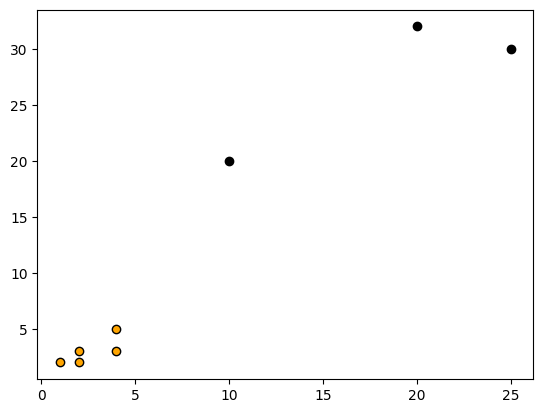

In [25]:
#plot each cluster onto a scatterplot.
plt.scatter(c1[:,0],c1[:,1],color='orange',edgecolor='black')
plt.scatter(c2[:,0],c2[:,1],color='black',edgecolor='black')

### Predict the cluster id of the query observation (10,6)

In [26]:
#store the likelihood in a list
llh_pred = []

#create the query record in a 2D array
pred = np.array([10,6])

#Calculate the likelihoods by runing multiPDF() for each cluster mean/covar
llh_pred.append(multiPDF(pred,c1_mean,c1_covar))
llh_pred.append(multiPDF(pred,c2_mean,c2_covar))

llh_pred

[1.1171988851018099e-11, 2.867170786405658e-11]

In [27]:
#Calculate the probabilities from the likelihoods using etep()
#This returns the fuzzy cluster value
estep(llh_pred[0],llh_pred[1])

(0.2803953892860355, 0.7196046107139645)

In [28]:
#return the cluster id that 10,6 is likely to be part of
np.argmax(estep(llh_pred[0],llh_pred[1]))

1

### Use SciKitLearn's GMM package to calculate the GMM Fuzzy Clusters using the same dataset q to confirm manual GMM results.

In [29]:
from sklearn.mixture import GaussianMixture as GMM

In [30]:
#Create an object reference of GMM. Create 2 clusters using n_components
model = GMM(n_components=2,verbose=True,verbose_interval=1)

In [31]:
#Fit the model using the dataset q and return the labels in a single statement using the convenience method fit_predict
label = model.fit_predict(q)

Initialization 0
  Iteration 1
  Iteration 2
Initialization converged: True


In [32]:
label

array([1, 0, 0, 0, 1, 1, 0, 0], dtype=int64)

In [33]:
#Display the final means of the converged clusters
model.means_

array([[ 2.59999995,  2.99999993],
       [18.33333238, 27.33333185]])

In [34]:
#Display the final covariances of the converged clusters
model.covariances_

array([[[ 1.44000098,  0.99999994],
        [ 0.99999994,  1.2000009 ]],

       [[38.88890118, 28.8889085 ],
        [28.8889085 , 27.55558817]]])

In [35]:
#Display the cluster probabilities of each row in the dataset q.
#This is the fuzzy cluter results.
model.predict_proba(q)

array([[9.81875758e-131, 1.00000000e+000],
       [9.99999995e-001, 5.09488968e-009],
       [9.99999993e-001, 7.21967107e-009],
       [9.99999818e-001, 1.81567252e-007],
       [1.68765248e-067, 1.00000000e+000],
       [2.18608101e-167, 1.00000000e+000],
       [9.99999997e-001, 2.53258879e-009],
       [9.99999999e-001, 1.05977353e-009]])

In [36]:
#display the log-likelihood of each row in q.  This is equal to each row's totaled likelihoods then taking the 
#log of the sum:   np.log(np.sum(row's likelihood, axis=1))

score = model.score_samples(q)
score

array([-6.5528151 , -3.05025343, -2.44585787, -3.87442806, -6.55281422,
       -6.55281404, -3.76453543, -2.6106931 ])

In [37]:
#display the average log-likelihood of all rows in q.
#This is equal to np.mean(model.score_samples(q))
model.score(q)

-4.425526408391502

In [38]:
#manually calculate the log likelihood of the final manual GMM likelihood array above
#this is not to be compared to the model.score_samples above, as the likelihoods are different, but they should
#be close.
np.log(np.sum(llh_array,axis=1))

array([-6.3725456 , -3.82475087, -4.33780421, -6.84858741, -6.0362462 ,
       -6.0362462 , -5.25494383, -3.97798583])

In [39]:
#take the difference of the two likelihoods
np.log(np.sum(llh_array,axis=1)) - score

array([ 0.1802695 , -0.77449743, -1.89194635, -2.97415935,  0.51656802,
        0.51656785, -1.4904084 , -1.36729272])

In [40]:
#Predict the cluster probabilities for the (10,6) query record we created before:
model.predict_proba(np.array([[10,6]]))

array([[0.39372668, 0.60627332]])

In [41]:
#Display the predicted cluster label for the (10,6) query record we created before:
model.predict(np.array([[10,6]]))

array([1], dtype=int64)

In [42]:
#Akaike Info Criterion value for comparing model parameters
model.aic(q)

92.80842253426403

In [43]:
#Bayesian Info Criterion value for comparing model parameters
model.bic(q)

93.68227949274223

### Create a scatter subplot to compare the manual GMM vs SKLearn's results

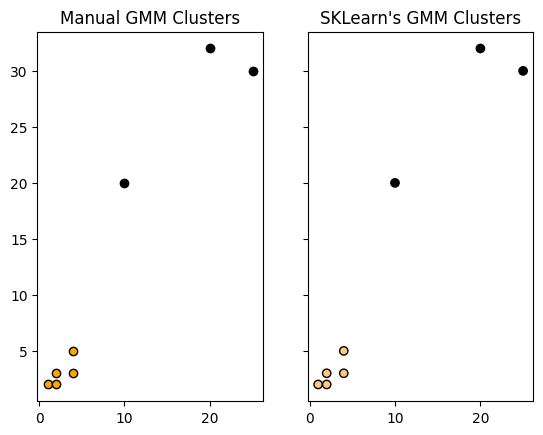

In [44]:
#create subplot and figure objects; share both axes
fig, ax = plt.subplots(1,2,sharey=True,sharex=True)

#plot get_PDF() results in leftmost subplot

ax[0].scatter(c1[:,0],c1[:,1],color='orange',edgecolor='black')
ax[0].scatter(c2[:,0],c2[:,1],color='black',edgecolor='black')
ax[0].title.set_text('Manual GMM Clusters')

ax[1].scatter(q[:,0],q[:,1],c=label,cmap='copper_r',edgecolor='black')
ax[1].title.set_text('SKLearn\'s GMM Clusters')

### Generate 150 random Gaussian distribution samples using the fitted model.  Use manual GMM algorithm and SKLearn to form the clusters.  Compare the results in a subplot scatterplot.

In [45]:
#Create the 150 random samples
model.random_state = 99
spl = model.sample(150)

In [46]:
spl[0]

array([[ 1.78315082,  3.26960442],
       [ 2.80206983,  3.12765718],
       [ 1.43175897,  2.5808974 ],
       [ 3.60793198,  2.12379409],
       [ 2.53621977,  3.45588351],
       [ 2.40384825,  3.167078  ],
       [ 2.82397894,  2.12576183],
       [ 1.80789003,  1.86353705],
       [ 2.95300892,  3.75503242],
       [ 3.3377245 ,  3.85020303],
       [ 3.64619774,  3.78794771],
       [ 3.19768003,  3.18483352],
       [ 3.54845936,  3.80771026],
       [ 2.11784803,  3.26457619],
       [ 3.23525181,  3.60298478],
       [-0.06431067,  0.92925495],
       [ 1.88830489,  2.69260351],
       [ 4.63538731,  4.62337461],
       [ 4.72201406,  5.52660163],
       [ 0.85599664,  1.0573961 ],
       [ 1.00392969,  0.74538847],
       [ 3.75501057,  4.43796972],
       [ 3.71550398,  3.61830665],
       [ 1.72223728,  1.49251299],
       [ 2.96546727,  3.23659283],
       [ 1.89624187,  2.9231012 ],
       [ 3.16313047,  2.60332972],
       [ 0.38011043,  3.18045985],
       [ 1.45581016,

In [47]:
#determine the clusters using manual GMM process.
c1, c2 = get_clusters(spl[0])


Iteration Nbr: 1

Cluster1 mean/covar [2.54534781 3.05581874] 
 [[1.47815803 1.04486673]
 [1.04486673 1.18030102]]
Cluster2 mean/covar [17.97761661 26.83245816] 
 [[46.34591248 33.09345462]
 [33.09345462 29.33436316]]

Iteration Nbr: 2

Cluster1 mean/covar [2.54864702 3.05916926] 
 [[1.4872902  1.05457227]
 [1.05457227 1.19007803]]
Cluster2 mean/covar [17.97761658 26.83245814] 
 [[46.34591296 33.09345492]
 [33.09345492 29.33436333]]

Iteration Nbr: 3

Cluster1 mean/covar [2.54864703 3.05916928] 
 [[1.48729024 1.05457231]
 [1.05457231 1.19007808]]
Cluster2 mean/covar [17.97761658 26.83245814] 
 [[46.34591296 33.09345492]
 [33.09345492 29.33436333]]

Iteration Nbr: 4

Cluster1 mean/covar [2.54864703 3.05916928] 
 [[1.48729024 1.05457231]
 [1.05457231 1.19007808]]
Cluster2 mean/covar [17.97761658 26.83245814] 
 [[46.34591296 33.09345492]
 [33.09345492 29.33436333]]

Iteration Nbr: 5

# OF ITERATIONS UNTIL CLUSTER CONVERGENCE:  5


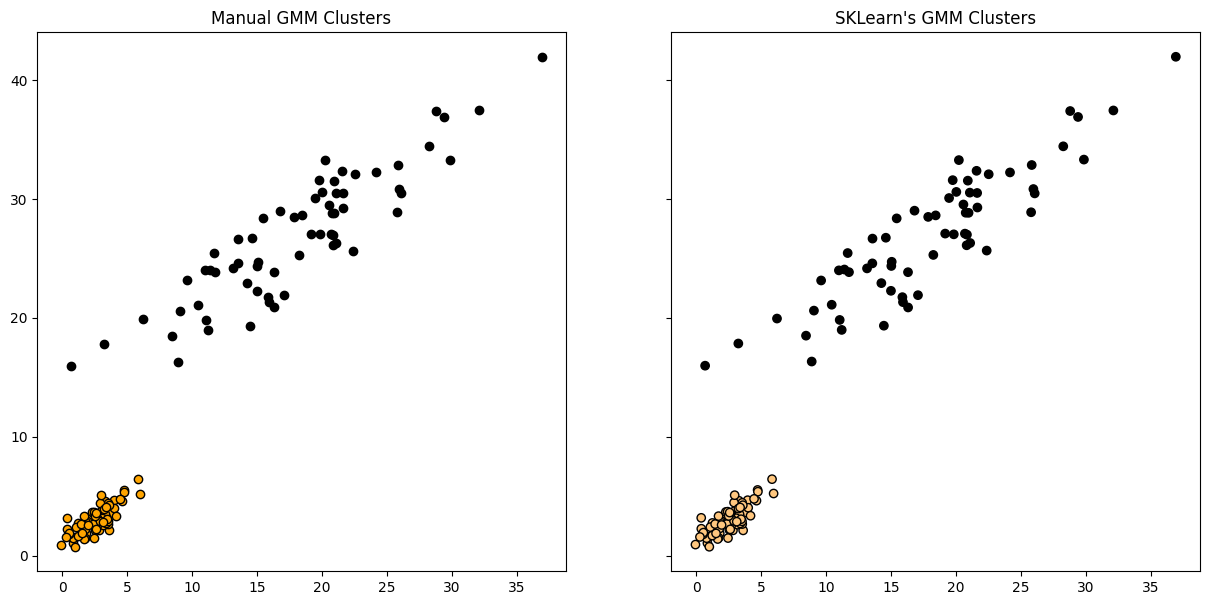

In [48]:
#plot results
fig, ax = plt.subplots(1,2,sharey=True,sharex=True,figsize=(15,7))


#plot the predicted clusters from manual GMM algorithm
ax[0].scatter(c2[:,0],c2[:,1],color='black',edgecolor='black')
ax[0].scatter(c1[:,0],c1[:,1],color='orange', edgecolor='black')
ax[0].title.set_text('Manual GMM Clusters')

#plot the 1K samples and predicted clusters from SKLearn's fitted model
ax[1].scatter(spl[0][:,0],spl[0][:,1],c=spl[1],cmap='copper_r',edgecolor='black')
ax[1].title.set_text('SKLearn\'s GMM Clusters')

### The above results appear to be identical.  It is conclusive that the manual implementation of the GMM  effectively replicates the functionality of Scikit-learn's GMM algorithm.